# Importaciones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Configuración para mostrar gráficos
%matplotlib inline
print("Versión de TensorFlow:", tf.__version__)

2025-11-19 18:30:41.896358: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-19 18:30:41.903385: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 18:30:42.165589: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-19 18:30:43.519271: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Versión de TensorFlow: 2.20.0


### Configuracion de rutas y lectura de metadata

In [2]:
# RUTAS: Ajusta esto a tu entorno local o de Colab
base_dir = './data/' # <--- CAMBIA ESTO A TU RUTA
metadata_path = os.path.join(base_dir, 'HAM10000_metadata.csv')

# A veces las imágenes vienen en dos carpetas (part1 y part2), aquí las unificamos virtualmente
# Buscamos todas las imágenes .jpg recursivamente en el directorio base
image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

# Leemos el CSV
df = pd.read_csv(metadata_path)

# Mapeamos el ID de la imagen a su ruta real
df['path'] = df['image_id'].map(image_path_dict)

# Verificamos que se encontraron las imágenes
print(f"Total de imágenes en CSV: {len(df)}")
print(f"Imágenes encontradas: {df['path'].notnull().sum()}")

# Eliminamos filas si no se encontró la imagen
df = df.dropna(subset=['path'])
df.head()

Total de imágenes en CSV: 10015
Imágenes encontradas: 10015


,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./data/ham10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./data/ham10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./data/ham10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./data/ham10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./data/ham10000_images_part_2/ISIC_0031633.jpg


### Exploracion de datos

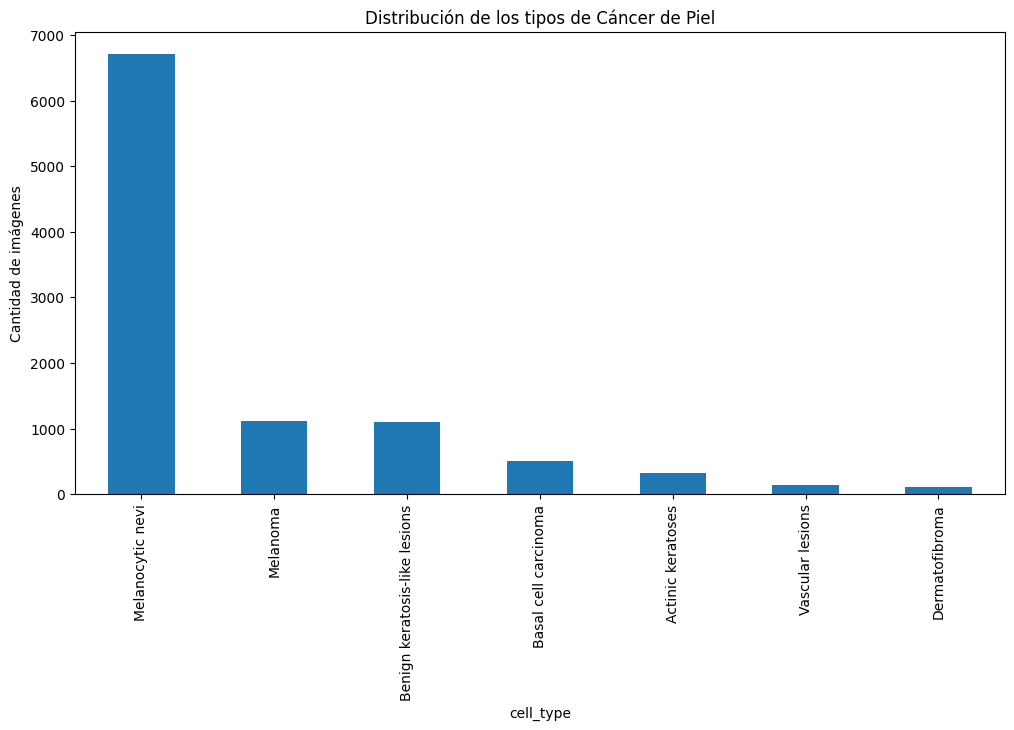

In [3]:
# Diccionario de abreviaturas a nombres reales
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['cell_type'] = df['dx'].map(lesion_type_dict)

# Graficar distribución
plt.figure(figsize=(12, 6))
df['cell_type'].value_counts().plot(kind='bar')
plt.title('Distribución de los tipos de Cáncer de Piel')
plt.ylabel('Cantidad de imágenes')
plt.show()

### Visualizacion de muestras

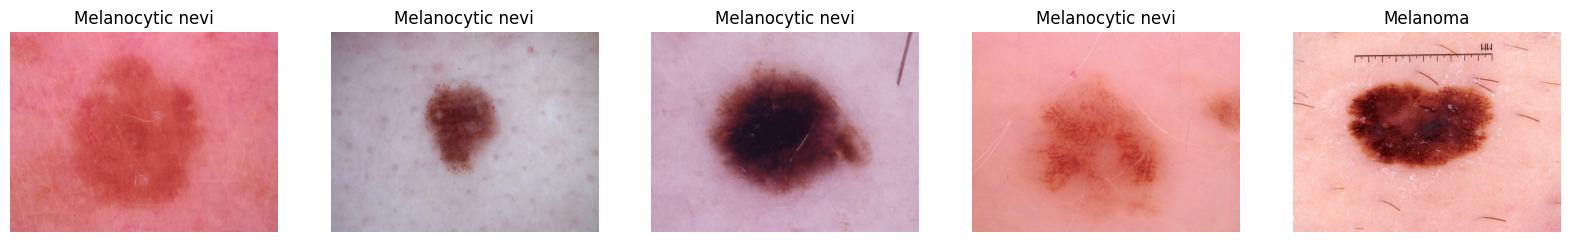

In [4]:
# Mostramos 5 imágenes aleatorias
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
sample_df = df.sample(5)

for i, (index, row) in enumerate(sample_df.iterrows()):
    img = cv2.imread(row['path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].set_title(row['cell_type'])
    axs[i].axis('off')
plt.show()

### Prearacion del Generador de Datos

In [5]:
# Parámetros
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 7

# Dividimos el dataframe primero para asegurar estratificación
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['dx'])

# Generadores
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15 # Usamos parte del train para validación durante el entrenamiento
)

test_datagen = ImageDataGenerator(rescale=1./255)

print("Configurando generadores...")

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='dx', # La columna objetivo (etiquetas cortas 'nv', 'mel', etc)
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='dx',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='dx',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Configurando generadores...
Found 7236 validated image filenames belonging to 7 classes.
Found 1276 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.


### Definicion de modelos AlexNet y ResNet

In [6]:
def build_resnet50(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    # Congelar capas base
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=base_model.input, outputs=predictions, name="ResNet50_Skin")
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_alexnet(num_classes):
    model = models.Sequential(name="AlexNet_Skin")
    # 1ra Capa Conv
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3), padding='valid'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())
    
    # 2da Capa Conv
    model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())
    
    # 3ra, 4ta, 5ta Capas Conv
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # Fully Connected
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Seleccion y entrenamiento

In [7]:
# === SELECCIONA TU MODELO AQUÍ ===
model = build_resnet50(NUM_CLASSES)

model.summary()

# Callbacks para mejorar el entrenamiento
checkpoint = ModelCheckpoint('mejor_modelo_skin.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entrenar
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=valid_generator,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

2025-11-19 18:30:44.508507: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "ResNet50_Skin"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,693,063 (98.01 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6277 - loss: 1.3389
Epoch 1: val_accuracy improved from None to 0.68260, saving model to mejor_modelo_skin.keras
227/227 ━━━━━━━━━━━━━━━━━━━━ 829s 4s/step - accuracy: 0.6462 - loss: 1.2682 - val_accuracy: 0.6826 - val_loss: 1.0894 - learning_rate: 1.0000e-04
Epoch 2/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6683 - loss: 1.1685
Epoch 2: val_accuracy did not improve from 0.68260
227/227 ━━━━━━━━━━━━━━━━━━━━ 774s 3s/step - accuracy: 0.6658 - loss: 1.1778 - val_accuracy: 0.6826 - val_loss: 1.0931 - learning_rate: 1.0000e-04
Epoch 3/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6670 - loss: 1.1654
Epoch 3: val_accuracy did not improve from 0.68260
227/227 ━━━━━━━━━━━━━━━━━━━━ 768s 3s/step - accuracy: 0.6674 - loss: 1.1529 - val_accuracy: 0.6826 - val_loss: 1.0786 - learning_rate: 1.0000e-04
Epoch 4/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6721 - loss: 1.1392
Epoch 4: val_accuracy did n

### Graficas de Redimiento

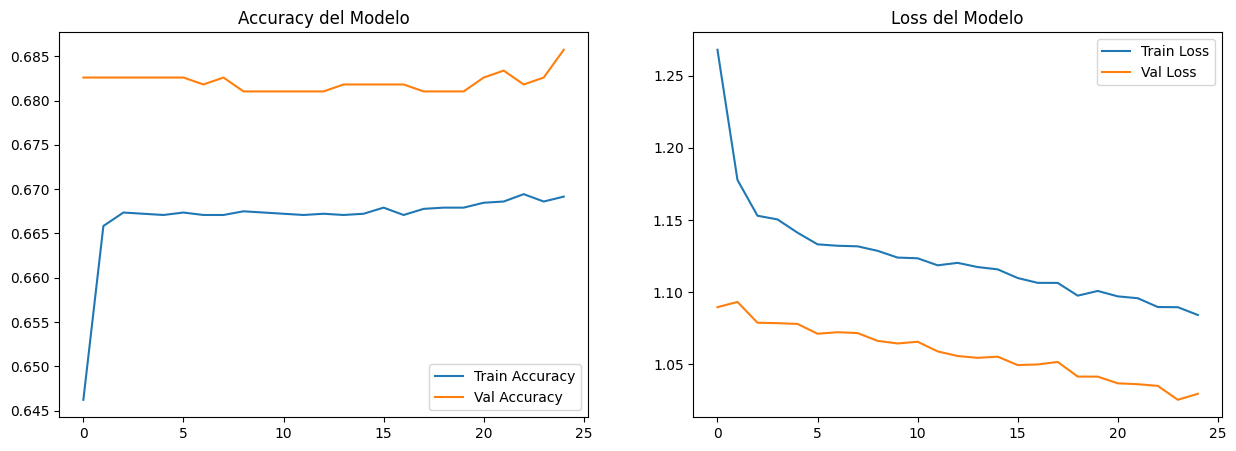

In [8]:
plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy del Modelo')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss del Modelo')
plt.legend()

plt.show()

### Evaluacion del modelo

In [9]:
print("Evaluando en el conjunto de Test...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión Final en Test: {test_acc*100:.2f}%")

Evaluando en el conjunto de Test...
47/47 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.6700 - loss: 1.0620
Precisión Final en Test: 67.00%
